In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arch
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.ndimage.interpolation import shift

In [148]:
# Get the Data

df = pd.read_excel('homework_1_epfl_2019.xls')
bitcoin = df['bitcoin']
ethereum = df['ethereum']
r = df['rf']/365 # now it is a daily return
dates = df.date[1:] #because we have daily returns started from day 1 (not 0)

In [149]:
# Compute the (daily) log-returns of the two cryptocurrencies;
R_bitcoin = []
r_bitcoin = []
R_ethereum = []
r_ethereum = []

for i in range(1,len(bitcoin)):
    R_bitcoin.append((bitcoin[i] - bitcoin[i-1])/bitcoin[i-1])
    R_ethereum.append((ethereum[i] - ethereum[i-1])/ethereum[i-1])
    
r_bitcoin = np.log(1 + np.array(R_bitcoin)) 
r_ethereum = np.log(1 + np.array(R_ethereum)) 

# Compute the (daily) log-returns of the risk free asset:
rf = np.log(1 + r/100)

# Compute the excess log-returns of the cryptocurrency : r_1t - bitcoin; r_2t - ethereum
r_1t = r_bitcoin - rf[1:]
r_2t = r_ethereum - rf[1:]

## Preliminary step: Characterization of the (co-) volatility

#### Plot an EWMA-based estimate of the (weekly) volatility.
Following Chapter1_Supplement_Describing slide 16 we define the EWMA volatility as
$$\sigma_t^2 = \phi\sigma_{t-1}^2 + (1-\phi)(r_{t-1} - \hat \mu)^2$$
$$\sigma_t^2 = (1-\phi)\sum_{k=1}^{t-1}\phi^{k-1}a_{k} $$

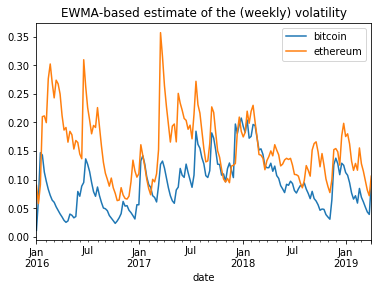

In [150]:
bit = {'r_bitcoin' : r_bitcoin}
bit = pd.DataFrame(bit)
b = bit.ewm(alpha = 0.06).std() #daily EWMA estimate for bitcoin

eth = {'r_ethereum' : r_ethereum}
eth = pd.DataFrame(eth)
e = eth.ewm(alpha = 0.06).std()#daily EWMA estimate for ethereum

#Weekly return will be a daily retyrn*np.sqrt(7)
#Prepare a data
EWMA = pd.DataFrame({'date' : dates, 'bitcoin' : np.sqrt(7)*b['r_bitcoin'].values, 'ethereum' : np.sqrt(7)*e['r_ethereum'].values})
EWMA.set_index('date', inplace = True)

EWMA_weekly = EWMA.asfreq('W')
EWMA_weekly.plot()
plt.title('EWMA-based estimate of the (weekly) volatility')
plt.legend()

#### Plot a GARCH-based estimate of the (weekly) volatility.

Text(0.5, 1.0, 'GARCH-based estimate of the (weekly) volatility')

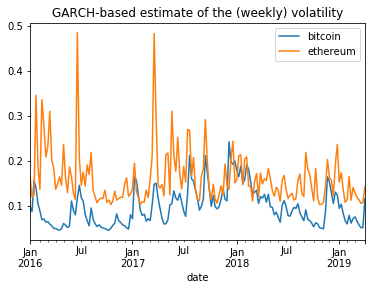

In [151]:
#bitcoin
#fit the GARCH model
am = arch_model(r_bitcoin) #p=1, o=1, q=1
res_bit = am.fit(disp = "off", update_freq = 7)

#ethereum
#fit the GARCH model
am = arch_model(r_ethereum) #p=1, o=1, q=1
res_eth = am.fit(disp = "off", update_freq = 7)

GARCH_param = pd.DataFrame({'currency' : ['bitcoin', 'ethereum'], 'omega' : [res_bit.params['omega'], res_eth.params['omega']],
                            'alpha' : [res_bit.params['alpha[1]'], res_eth.params['alpha[1]']],
                            'beta' : [res_bit.params['beta[1]'], res_eth.params['beta[1]']]})
GARCH_param.set_index('currency', inplace = True)

GARCH = pd.DataFrame({'date':dates, 'bitcoin':res_bit._volatility, 'ethereum':res_eth._volatility})
GARCH.set_index('date', inplace = True)
GARCH_weekly = (GARCH*np.sqrt(7)).asfreq("W")
GARCH_weekly.plot()
plt.title('GARCH-based estimate of the (weekly) volatility')

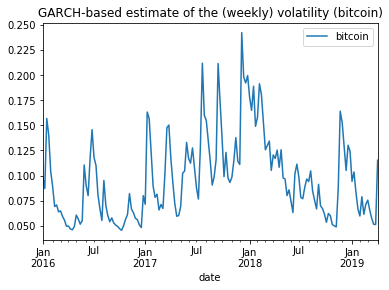

In [152]:
GARCH_weekly['bitcoin'].plot(label = 'bitcoin')
plt.title('GARCH-based estimate of the (weekly) volatility (bitcoin)')
plt.legend()

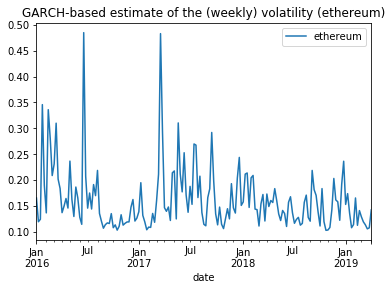

In [153]:
GARCH_weekly['ethereum'].plot(label = 'ethereum')
plt.title('GARCH-based estimate of the (weekly) volatility (ethereum)')
plt.legend()

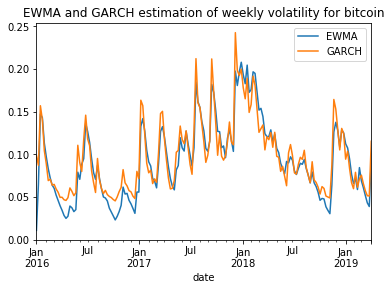

In [154]:
#Compare EWMA and GARCH
EWMA_weekly['bitcoin'].plot(label = 'EWMA')
GARCH_weekly['bitcoin'].plot(label = 'GARCH')
plt.title('EWMA and GARCH estimation of weekly volatility for bitcoin')
plt.legend()

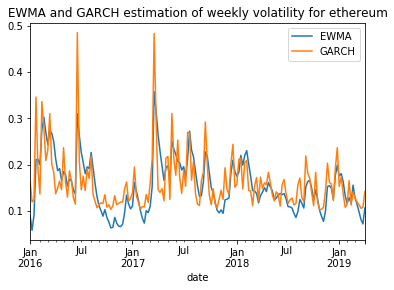

In [155]:
EWMA_weekly['ethereum'].plot(label = 'EWMA')
GARCH_weekly['ethereum'].plot(label = 'GARCH')
plt.title('EWMA and GARCH estimation of weekly volatility for ethereum')
plt.legend()

#### Compute the term structure of volatility over the next 21 days.

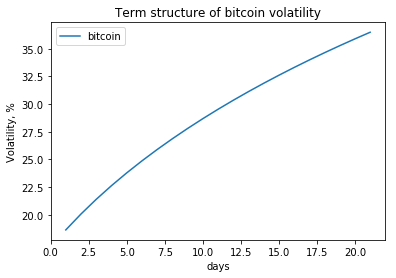

In [156]:
horizon = np.linspace(1, 21, 21)
m_bitcoin = (r_bitcoin - np.mean(r_bitcoin))**2

conditional_variance_bitcoin = np.zeros(len(m_bitcoin))
conditional_variance_bitcoin[0] = res_bit.params['omega'] + res_bit.params['alpha[1]']*np.mean(m_bitcoin)

for i in np.arange(1, len(conditional_variance_bitcoin)-1, 1):
    conditional_variance_bitcoin[i] = (res_bit.params['omega'] + res_bit.params['alpha[1]']*m_bitcoin[i-1] + 
                               res_bit.params['beta[1]']*conditional_variance_bitcoin[i-1])
    
forward_variance_bitcoin = np.zeros(len(horizon))
forward_variance_bitcoin[0] = (res_bit.params['omega'] + res_bit.params['alpha[1]']*m_bitcoin[-1] + 
                              res_bit.params['beta[1]'] * conditional_variance_bitcoin[-1])

for i in np.arange(1, len(forward_variance_bitcoin), 1):
    forward_variance_bitcoin[i] = (res_bit.params['omega'] + 
                           forward_variance_bitcoin[i-1] * (res_bit.params['alpha[1]'] + res_bit.params['beta[1]']))
    
cumulative_forward_var_bitcoin = np.zeros(len(forward_variance_bitcoin))
cumulative_forward_var_bitcoin[0] = forward_variance_bitcoin[0]

for i in np.arange(1, len(cumulative_forward_var_bitcoin), 1):
    cumulative_forward_var_bitcoin[i] = cumulative_forward_var_bitcoin[i-1] + forward_variance_bitcoin[i]
    
term_structure_bitcoin = np.zeros(len(cumulative_forward_var_bitcoin))
for i in range(len(term_structure_bitcoin)):
    term_structure_bitcoin[i] = np.sqrt(cumulative_forward_var_bitcoin[i] * 365/(i+1))

plt.plot(horizon, term_structure_bitcoin*100, label = 'bitcoin')
plt.xlabel('days')
plt.ylabel('Volatility, %')
plt.title('Term structure of bitcoin volatility')
plt.legend()

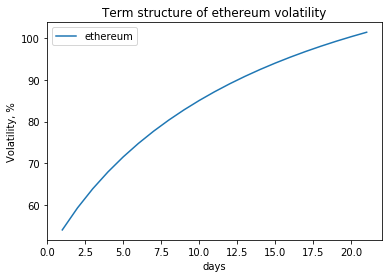

In [157]:
horizon = np.linspace(1, 21, 21)
m_ethereum = (r_ethereum - np.mean(r_ethereum))**2

conditional_variance_ethereum = np.zeros(len(m_ethereum))
conditional_variance_ethereum[0] = res_eth.params['omega'] + res_eth.params['alpha[1]']*np.mean(m_ethereum)

for i in np.arange(1, len(conditional_variance_ethereum)-1, 1):
    conditional_variance_ethereum[i] = (res_eth.params['omega'] + res_eth.params['alpha[1]']*m_ethereum[i-1] + 
                               res_eth.params['beta[1]']*conditional_variance_ethereum[i-1])
    
forward_variance_ethereum = np.zeros(len(horizon))
forward_variance_ethereum[0] = (res_eth.params['omega'] + res_eth.params['alpha[1]']*m_ethereum[-1] + 
                              res_eth.params['beta[1]'] * conditional_variance_ethereum[-1])

for i in np.arange(1, len(forward_variance_ethereum), 1):
    forward_variance_ethereum[i] = (res_eth.params['omega'] + 
                           forward_variance_ethereum[i-1] * (res_eth.params['alpha[1]'] + res_eth.params['beta[1]']))
    
cumulative_forward_var_ethereum = np.zeros(len(forward_variance_ethereum))
cumulative_forward_var_ethereum[0] = forward_variance_ethereum[0]

for i in np.arange(1, len(cumulative_forward_var_ethereum), 1):
    cumulative_forward_var_ethereum[i] = cumulative_forward_var_ethereum[i-1] + forward_variance_ethereum[i]
    
term_structure_ethereum = np.zeros(len(cumulative_forward_var_ethereum))
for i in range(len(term_structure_ethereum)):
    term_structure_ethereum[i] = np.sqrt(cumulative_forward_var_ethereum[i] * 365/(i+1))

plt.plot(horizon, term_structure_ethereum*100, label = 'ethereum')
plt.xlabel('days')
plt.ylabel('Volatility, %')
plt.title('Term structure of ethereum volatility')
plt.legend()

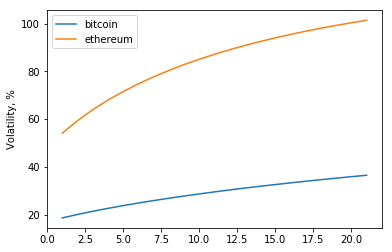

In [158]:
plt.plot(horizon, term_structure_bitcoin*100, label = 'bitcoin')
plt.plot(horizon, term_structure_ethereum*100, label = 'ethereum')
plt.ylabel('Volatility, %')
plt.legend()

### Provide some measures of conditional and unconditionnal correlation(s) between the two (log-) returns.

0.4505024223515869


Text(0.5, 1.0, 'Conditional and unconditional correlation')

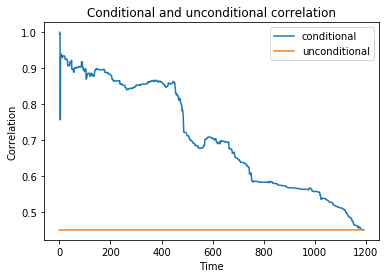

In [181]:
#unconditional correlation
correlation = np.corrcoef(r_bitcoin, r_ethereum)
corr = correlation[0][1] * np.ones((len(r_bitcoin),1))

print(correlation[0][1])

#conditional correlation
corr_2 = []

for i in range(0, len(r_bitcoin)):
    new_b = r_bitcoin[i:]
    new_e = r_ethereum[i:]
    
    cond_correlation = np.corrcoef(new_b, new_e)
    corr_2.append(cond_correlation[0][1])
    
corr_2.reverse()
plt.plot(corr_2, label = 'conditional')
plt.plot(corr,label = 'unconditional')
plt.ylabel("Correlation")
plt.xlabel("Time")
plt.legend()
plt.title('Conditional and unconditional correlation')

# Static allocation using the constant expected returns model

Use $\mu[2]$ = 2 * average of r_b2 (r_e2)


In [275]:
#Compute the 2-period moments mu[2] and Sigma[2]

mu_b2 = 2*np.mean(r_bitcoin)
mu_e2 = 2*np.mean(r_ethereum)
mu_r2 = 2*np.mean(rf)
mu_2 = [mu_b2 - mu_r2, mu_e2 - mu_r2, mu_r2] # This is mu[2]
print("mu_2 = ", mu_2)
print("-----------------------")

Sigma = 2*np.cov(r_bitcoin, r_ethereum) # This is Sigma[2]

print("Sigma = ")
print(Sigma)
print("-----------------------")

#function we will minimize 
#originally we must max, so we put - before the function and minimize
def objective_function(x, lambd, mu_2, Sigma):
    x = np.array(x)
    mu_2 = np.array(mu_2)
    return -(x@mu_2[:2] + mu_2[2] - (lambd/2) * x @ Sigma @ np.transpose(x))

   
# we will use it once we solve the optimization problem
def description(x, lambd):
    print("For lambda = ", lambd)
    print("The optimal weights are ")
    print(x.x)
    print("The maximum of the utility function = ", -x.fun)

# Compute the optimal weights for lambda = 2
xinit = [0.4, 0.5]
res_2 = minimize(objective_function, x0=xinit, args = (2, mu_2, Sigma))
description(res_2, 2)
print("--------------------------")
# Compute the optimal weights for lambda = 10
res_10 = minimize(objective_function, x0=xinit, args = (10, mu_2, Sigma))
description(res_10, 10)


#For latex:
# resw = { 'lambda' : [2, 10], 'w_b': [res_2.x[0], res_10.x[0]],'w_e': [res_2.x[1], res_10.x[1]], 
#            'max(f)': [-res_2.fun, -res_10.fun] }
# resw = pd.DataFrame(resw)
# resw.set_index('lambda')
# print(resw.to_latex())

mu_2 =  [0.004100209723143058, 0.008685904987116641, 6.488713910587069e-05]
-----------------------
Sigma = 
[[0.00315781 0.0022912 ]
 [0.0022912  0.00819116]]
-----------------------
For lambda =  2
The optimal weights are 
[0.33187783 0.4373665 ]
The maximum of the utility function =  0.0026447414372823977
--------------------------
For lambda =  10
The optimal weights are 
[0.06637528 0.08747275]
The maximum of the utility function =  0.0005808579987048298


Now we can notice that instead of solving the optimization problem we could compute the weights by using the formula from the FOC of the optimization problem:
$$w = [w_1, w_2] = \frac{1}{\lambda} \Sigma^{-1}\mu $$


In [276]:
InvSigma = np.linalg.inv(Sigma) 
# Compute the optimal weights for lambda = 2
w_2s = 1/2 * InvSigma@mu_2[:2]
w_2s = np.array([w_2s[0], w_2s[1], 1 - np.sum(w_2s)])

# Compute the optimal weights for lambda = 10
w_10s = 1/10 * InvSigma@mu_2[:2]
w_10s = np.array([w_10s[0], w_10s[1], 1 - np.sum(w_10s)])

print("The weights for lambda = 2:")
print(w_2s)
print("-----------------------------")
print("The weights for lambda = 10:")
print(w_10s)

# For latex
# resw = { 'lambda' : [2, 10], 'w_b': [w_2s[0], w_10s[0]],'w_e': [w_2s[1], w_10s[1]]}
# resw = pd.DataFrame(resw)
# resw.set_index('lambda')
# print(resw.to_latex())

The weights for lambda = 2:
[0.33187872 0.43736793 0.23075335]
-----------------------------
The weights for lambda = 10:
[0.06637574 0.08747359 0.84615067]


# Dynamic asset allocation with time-varying volatility

## Determination of Sigma[2]

### Write down the 1-step ahead and the 2-step ahead variance forecast

$$\sigma_t^2(1) = \omega + \alpha_1 (r_t - \bar r)^2 + \beta_1\sigma_t^2 \ \ \ (*)$$
$$\sigma_t^2(2) = \omega + (\alpha_1 + \beta_1)\sigma_t^2(1) \ \ \ (**) $$

In the formulas above $\sigma_t^2$ is a realised volatility. We will use our GARCH estimation of the volatility here

In [277]:
#bitcoin
m_bitcoin = (r_bitcoin - np.mean(r_bitcoin))**2
# we use our GARCH specification from the difst question for sigma_t^2
vol_predict1_bitcoin = (res_bit.params['omega'] + res_bit.params['alpha[1]']*m_bitcoin + 
                        res_bit.params['beta[1]'] * res_bit._volatility**2 )
vol_predict2_bitcoin = res_bit.params['omega'] + (res_bit.params['alpha[1]'] + res_bit.params['beta[1]']) * vol_predict1_bitcoin

#ethereum
m_ethereum = (r_ethereum - np.mean(r_ethereum))**2
vol_predict1_ethereum = (res_eth.params['omega'] + res_eth.params['alpha[1]']*m_ethereum + 
                         res_eth.params['beta[1]'] * res_eth._volatility**2) 
vol_predict2_ethereum = res_eth.params['omega'] + (res_eth.params['alpha[1]'] + res_eth.params['beta[1]']) * vol_predict1_ethereum

### Write down the variance forecast for the 2-period (log-) returns $\sigma_t^2 = \mathbb{V}(\epsilon_{t+1} + \epsilon_{t+2}|I_t)$

$$\sigma_t^2 = \mathbb{V}(\epsilon_{t+1} + \epsilon_{t+2}|I_t) = \sigma_t^2(1) + \sigma_t^2(2) $$


Text(0.5, 1.0, 'Daily variance forecast for the 2-period (log-) returns')

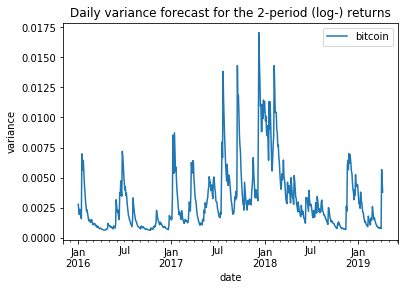

In [278]:
#bitcoin
vol_forecast_bitcoin = np.array(vol_predict1_bitcoin + vol_predict2_bitcoin) #it is a variance
#we hold a portfolio for 2 consequitive days so we need to have values with even indexes
vol_for_bit = []
for i in np.arange(0, len(vol_forecast_bitcoin), 2):
    vol_for_bit.append(vol_forecast_bitcoin[i]) 

vol_forecast_bitcoin = pd.Series(vol_for_bit, dates[1::2])

#ethereum
vol_forecast_ethereum = np.array(vol_predict1_ethereum + vol_predict2_ethereum) #it is a variance
vol_for_eth = []
for i in np.arange(0, len(vol_forecast_ethereum), 2):
    vol_for_eth.append(vol_forecast_ethereum[i]) 

vol_forecast_ethereum = pd.Series(vol_for_eth, dates[1::2])


vol_forecast_bitcoin.plot(label = 'bitcoin')
#vol_forecast_ethereum.plot(label = 'ethereum')
plt.ylabel("variance")
plt.legend()
plt.title('Daily variance forecast for the 2-period (log-) returns')

Text(0.5, 1.0, 'Daily variance forecast for the 2-period (log-) returns')

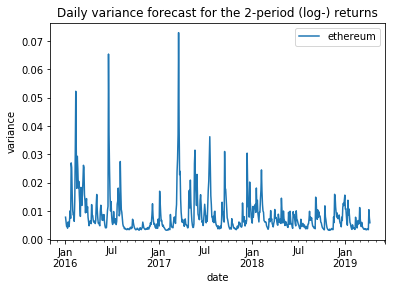

In [279]:
vol_forecast_ethereum.plot(label = 'ethereum')
plt.ylabel("variance")
plt.legend()
plt.title('Daily variance forecast for the 2-period (log-) returns')

Text(0.5, 1.0, 'Daily variance forecast for the 2-period (log-) returns')

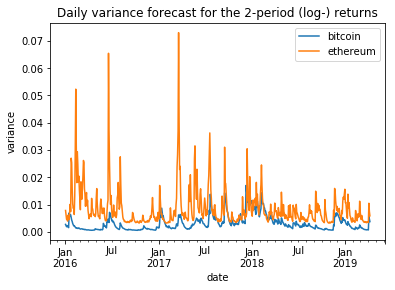

In [280]:
vol_forecast_bitcoin.plot(label = 'bitcoin')
vol_forecast_ethereum.plot(label = 'ethereum')
plt.ylabel("variance")
plt.legend()
plt.title('Daily variance forecast for the 2-period (log-) returns')

## Determination of optimal weights $w_t^*$

The first thing to do is to find a correlation between the residuals $\rho_{1,2}$. We are said to assume that it's a constant, so we can use numpy tool to find it

In [281]:
rho = np.corrcoef(r_bitcoin, r_ethereum)[0][1]
sigma12 = rho * np.sqrt(vol_forecast_bitcoin.values) * np.sqrt(vol_forecast_ethereum.values)

# number of layers - len(sigma_12)
Sigma_t = np.zeros((len(sigma12), 2, 2))

# Constructing Sigma_t[2]
for i in range(len(sigma12)):
    Sigma_t[i] = [[vol_forecast_bitcoin.values[i], sigma12[i]],
                  [sigma12[i], vol_forecast_ethereum.values[i]]]

Now lets determine the weights for the dynamic trading. As before there are 2 ways of doing that and we will use the direct formula we have obtained before

In [282]:
# lambda = 2
w_2d = np.zeros((len(sigma12), 3))
             
for i in range(len(sigma12)):
    stock2 = 1/2 * np.linalg.inv(Sigma_t[i]) @ mu_2[:2]
    w_2d[i] = [stock2[0], stock2[1], 1-np.sum(stock2)]

# lambda = 10
w_10d = np.zeros((len(sigma12), 3))
             
for i in range(len(sigma12)):
    stock10 = 1/10 * np.linalg.inv(Sigma_t[i]) @ mu_2[:2]
    w_10d[i] = [stock10[0], stock10[1], 1-np.sum(stock10)]

In [283]:
w_2d[:3]

array([[ 0.40120444,  0.4444727 ,  0.15432286],
       [ 0.46375638,  0.58315828, -0.04691466],
       [ 0.51711559,  0.77921119, -0.29632678]])

In [284]:
w_10d[:3]

array([[0.08024089, 0.08889454, 0.83086457],
       [0.09275128, 0.11663166, 0.79061707],
       [0.10342312, 0.15584224, 0.74073464]])

### plot the optimal weights of the stock index and the bond index

Text(0.5, 1.0, 'Lambda = 2')

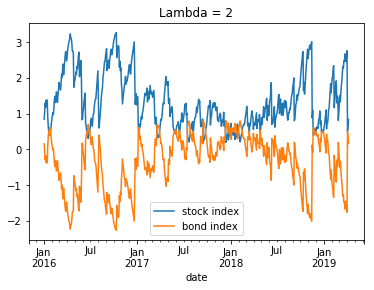

In [285]:
#lambda = 2
x = np.arange(0, len(w_2d), 1)
stock_index2 = np.zeros(len(w_2d))
bond_index2 = np.zeros(len(w_2d))
bit2 = np.zeros(len(w_2d))
eth2 = np.zeros(len(w_2d))

for i in range(len(w_2d)):
    stock_index2[i] = w_2d[i][0] + w_2d[i][1]
    bond_index2[i] = w_2d[i][2]
    bit2[i] = w_2d[i][0]
    eth2[i] = w_2d[i][1]


stock_index2 = pd.Series(stock_index2, dates[1::2])
bond_index2 = pd.Series(bond_index2, dates[1::2])
bit2 = pd.Series(bit2, dates[1::2])
eth2 = pd.Series(eth2, dates[1::2])
stock_index2.plot(label = 'stock index')
bond_index2.plot(label = 'bond index')
#bit2.plot(label = 'bitcoin')
#eth2.plot(label = 'ethereum')
plt.legend()
plt.title('Lambda = 2')

Text(0.5, 1.0, 'Lambda = 2')

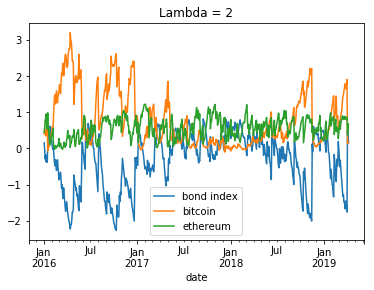

In [286]:
bond_index2.plot(label = 'bond index')
bit2.plot(label = 'bitcoin')
eth2.plot(label = 'ethereum')
plt.legend()
plt.title('Lambda = 2')

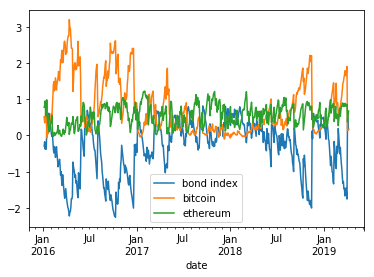

In [287]:
# Here we see bigger picture
bond_index2[2:].plot(label = 'bond index')
bit2[2:].plot(label = 'bitcoin')
eth2[2:].plot(label = 'ethereum')
plt.legend()

Text(0.5, 1.0, 'Lambda = 10')

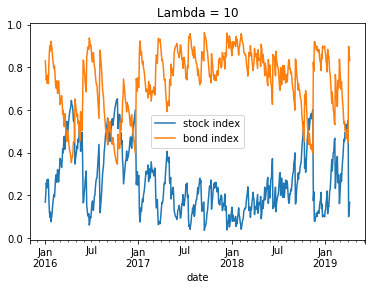

In [288]:
#lambda = 10
x = np.arange(0, len(w_10d), 1)
stock_index10 = np.zeros(len(w_10d))
bond_index10 = np.zeros(len(w_10d))
bit10 = np.zeros(len(w_2d))
eth10 = np.zeros(len(w_2d))

for i in range(len(w_10d)):
    stock_index10[i] = w_10d[i][0] + w_10d[i][1]
    bond_index10[i] = w_10d[i][2]
    bit10[i] = w_10d[i][0]
    eth10[i] = w_10d[i][1]


stock_index10 = pd.Series(stock_index10, dates[1::2])
bond_index10 = pd.Series(bond_index10, dates[1::2])
bit10 = pd.Series(bit10, dates[1::2])
eth10 = pd.Series(eth10, dates[1::2])
stock_index10.plot(label = 'stock index')
bond_index10.plot(label = 'bond index')
plt.legend()
plt.title('Lambda = 10')

Text(0.5, 1.0, 'Lambda = 10')

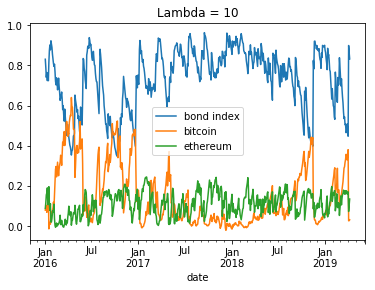

In [289]:
bond_index10.plot(label = 'bond index')
bit10.plot(label = 'bitcoin')
eth10.plot(label = 'ethereum')
plt.legend()
plt.title('Lambda = 10')

## Comparison

In [290]:
#Prepare a data for plotting the results. Here we get returns over 2 days
rb = r_bitcoin + shift(r_bitcoin, 1) # here we need the values for the indexes 1,3,5...
re = r_ethereum + shift(r_ethereum, 1)
rf = rf[1:] + shift(rf[1:], 1)
rf = rf.values

In [291]:
returns = np.zeros((len(w_2d), 3))
for i in range(len(returns)):
    returns[i] = [rb[2*i], re[2*i], rf[2*i]]

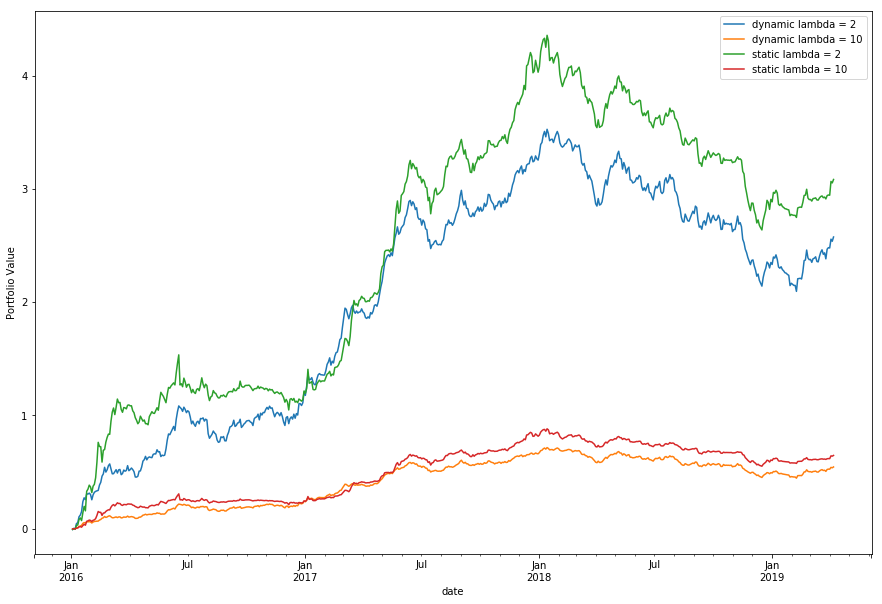

In [292]:
port2_dynamic = np.zeros(len(w_2d))
port10_dynamic = np.zeros(len(w_10d))
port2_static = np.zeros(len(w_2d))
port10_static = np.zeros(len(w_10d))

for i in np.arange(0, len(port2_dynamic), 1):
    
    port2_dynamic[i] = np.sum(w_2d[i] * returns[i])
    port10_dynamic[i] = np.sum(w_10d[i] * returns[i])
    port2_static[i] = np.sum(w_2s * returns[i])
    port10_static[i] = np.sum(w_10s * returns[i])
 
plt.figure(figsize = (15,10))

Portfolio_2_dynamic = np.asarray(pd.Series(port2_dynamic).cumsum()).ravel()
Portfolio2_dynamic = pd.Series(Portfolio_2_dynamic, dates[1::2])
Portfolio2_dynamic.plot(label = 'dynamic lambda = 2')  

Portfolio_10_dynamic = np.asarray(pd.Series(port10_dynamic).cumsum()).ravel()
Portfolio10_dynamic = pd.Series(Portfolio_10_dynamic, dates[1::2])
Portfolio10_dynamic.plot(label = 'dynamic lambda = 10')  

Portfolio_2_static = np.asarray(pd.Series(port2_static).cumsum()).ravel()
Portfolio2_static = pd.Series(Portfolio_2_static, dates[1::2])
Portfolio2_static.plot(label = 'static lambda = 2')  

Portfolio_10_static = np.asarray(pd.Series(port10_static).cumsum()).ravel()
Portfolio10_static = pd.Series(Portfolio_10_static, dates[1::2])
Portfolio10_static.plot(label = 'static lambda = 10') 

plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

## Pair trading

### Pair trading using an error correction model

Do you think that the two currencies that you have selected would be good candidates for a pair trading strategy using an error correction model? Explain your answer in detail. If needed, provide the appropriate analyses to support your argument.

In [135]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Test if the prices are stationary
# Null Hypotehsis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

result_bit = adfuller(bitcoin)
print('ADF test for bitcoin:')
print('ADF test statistic: %f' % result_bit[0])
print('p-value: %f' % result_bit[1])

result_eth = adfuller(ethereum)
print('ADF test for ethereum:')
print('ADF test statistic: %f' % result_eth[0])
print('p-value: %f' % result_eth[1])

ADF test for bitcoin:
ADF test statistic: -1.921482
p-value: 0.322024
ADF test for ethereum:
ADF test statistic: -1.987803
p-value: 0.291947


Because the p-values are superior to 0.05, we do not reject H0 in both cases: the prices' time-series for bitcoin and ethereum have a unit root (i.e. are I(1) series) and are non-stationary

In [136]:
# Specify the cointegrating relationship

Y = bitcoin
X = ethereum
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                bitcoin   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     4623.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        22:28:16   Log-Likelihood:                -10578.
No. Observations:                1193   AIC:                         2.116e+04
Df Residuals:                    1191   BIC:                         2.117e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1157.7893     65.277     17.737      0.0

In [137]:
# Test if the residuals are stationary
residuals = results.resid
adf_residuals = adfuller(residuals)
print('ADF test for the residuals:')
print('ADF test statistic: %f' % adf_residuals[0])
print('p-value: %f' % adf_residuals[1])


ADF test for the residuals:
ADF test statistic: -4.304883
p-value: 0.000436


The p-value is much smaller than 0.05, so we reject H0: the residuals time series does not have a unit root and is stationary.

Since the residuals are stationary, we can assume that the variables are cointegrated.

Therefore we see that both bitcoin's and ethereum's prices are integrated to the same order (I(1)) and that they are co-integrated. Using the Engle-Granger representation theorem, we can conclude that there exists an error correction model representation and that they are therefore good candidates for this strategy.

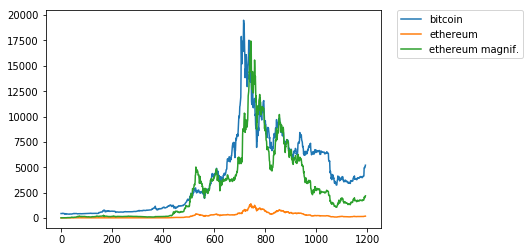

In [138]:
# Visual appreciation of co-integration relationship
plt.plot(bitcoin)
plt.plot(ethereum) # Est-ce que la magnitude c'est important?
plt.plot(12.5*ethereum, label = 'ethereum magnif.')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

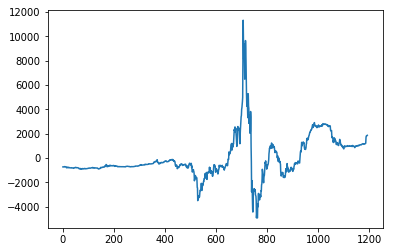

In [139]:
plt.plot(residuals)